### Imports
Lots of these aren't necessary but I've copied and pasted it straight from the Explore gene.ipynb notebook.

In [1]:
import pandas as pd
import scipy.stats
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

from sklearn.metrics import confusion_matrix

In [2]:
calculatedProperties = pd.read_csv("FH_complete_mutation_summary.csv")
calculatedProperties.head()

,Unnamed: 0,Residue,AAfrom,AAto,rhapsodyscore,rhapsodyclass,polyphenscore,polyphenclass,Foldx_energy,Rosetta_energy,Mutation,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,0,49,S,A,0.086,neutral,0.00,neutral,0.061363,3.265,S49A,1.663182,0.992308,23.461148,33.7131
1,1,49,S,C,0.535,neutral,0.86,deleterious,0.067352,7.990,S49C,4.028676,0.992308,23.461148,33.7131
2,2,49,S,D,0.052,neutral,0.00,neutral,-0.103203,1.891,S49D,0.893899,0.992308,23.461148,33.7131
3,3,49,S,E,0.049,neutral,0.00,neutral,-0.086741,0.983,S49E,0.448129,0.992308,23.461148,33.7131
4,4,49,S,F,0.529,neutral,0.62,deleterious,0.182080,4.837,S49F,2.509540,0.992308,23.461148,33.7131


In [3]:
calculatedProperties = calculatedProperties.drop(columns = ["Mutation","Unnamed: 0", "rhapsodyclass","rhapsodyscore","polyphenscore","polyphenclass"])
calculatedProperties

,Residue,AAfrom,AAto,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge
0,49,S,A,0.061363,3.265,1.663182,0.992308,23.461148,33.713100
1,49,S,C,0.067352,7.990,4.028676,0.992308,23.461148,33.713100
2,49,S,D,-0.103203,1.891,0.893899,0.992308,23.461148,33.713100
3,49,S,E,-0.086741,0.983,0.448129,0.992308,23.461148,33.713100
4,49,S,F,0.182080,4.837,2.509540,0.992308,23.461148,33.713100
...,...,...,...,...,...,...,...,...,...
8773,510,K,S,0.571362,1.871,1.221181,0.717073,14.891393,15.359364
8774,510,K,T,0.862076,1.330,1.096038,0.717073,14.891393,15.359364
8775,510,K,V,1.125190,-0.576,0.274595,0.717073,14.891393,15.359364
8776,510,K,W,0.686269,-0.158,0.264134,0.717073,14.891393,15.359364


In [4]:
BayesDel = pd.read_csv("./FH_mutations_BayesDel_Cleaned_2.csv")

In [5]:
# need to match column names to that of calculatedProperties
BayesDel.rename(columns={
    'aapos': 'Residue',
    'aaalt': 'AAto',
    'aaref': 'AAfrom'
}, inplace=True)

BayesDel.head()

,#chr,pos(1-based),ref,alt,genename,rs_dbSNP,AAfrom,AAto,Residue,HGVSc_VEP,HGVSp_VEP,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore
0,1,241497828,T,A,FH,.,X,C,511,c.1533A>T,p.Ter511CysextTer3,0.016367,-0.214267,0.53578
1,1,241497828,T,C,FH,.,X,W,511,c.1533A>G,p.Ter511TrpextTer3,0.048540,-0.168052,0.57861
2,1,241497828,T,G,FH,.,X,C,511,c.1533A>C,p.Ter511CysextTer3,0.019965,-0.209098,0.54067
3,1,241497829,C,A,FH,.,X,L,511,c.1532G>T,p.Ter511LeuextTer3,-0.136883,-0.434399,0.30031
4,1,241497829,C,G,FH,rs2147911168,X,S,511,c.1532G>C,p.Ter511SerextTer3,-0.148895,-0.451654,0.28133


In [6]:
# there's only some tables I want to keep
BayesDel = BayesDel[["AAfrom","AAto","Residue","BayesDel_addAF_score","BayesDel_noAF_score","BayesDel_addAF_rankscore"]]

In [7]:
# merging datasets to get ready for binary classification
BayesDel_calc = BayesDel.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])

In [8]:
BayesDel_calc["RSA_Foldx_interaction"] = BayesDel_calc["RSA"] * BayesDel_calc["Foldx_energy"]

In [9]:
bs_calc = BayesDel_calc[BayesDel_calc['BayesDel_noAF_score'] < -0.057]
ds_calc = BayesDel_calc[BayesDel_calc['BayesDel_noAF_score'] >= -0.057]

In [10]:
# converting tables to string to avoid potential errors
bs_calc = bs_calc.astype(str)
ds_calc = ds_calc.astype(str)

In [11]:
# add source column to benign and deleterious tables for classification
bs_calc["source"] = "neutral"
ds_calc["source"] = "deleterious"

In [12]:
logreg_data = pd.concat([bs_calc, ds_calc])

logreg_data = pd.get_dummies(logreg_data, columns = ["source"], drop_first = False)

logreg_data

,AAfrom,AAto,Residue,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge,RSA_Foldx_interaction,source_deleterious,source_neutral
22,L,V,507,0.125399,-0.0576501,0.66673,1.88196,2.48,2.18098,0.213414634,15.11647605,6.032148733,0.40163780460264,0,1
33,D,E,505,-0.0749932,-0.345499,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,-0.21266149699386,0,1
34,D,E,505,-0.0749939,-0.3455,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,-0.21266149699386,0,1
40,D,N,505,-0.00212996,-0.240836,0.51039,-0.211858,0.82,0.304071,0.63803681,18.71564022,10.63279724,-0.13517320249297998,0,1
41,K,N,504,-0.0242995,-0.272681,0.47907,1.27046,3.16,2.21523,0.712195122,19.79394051,9.103497551,0.9048154146961199,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054,F,I,50,0.206988,0.0595479,0.74357,2.2606,1.613,1.9368,0.538071066,20.36104043,31.8387706,1.2163634517996,1,0
3055,S,F,49,0.206421,0.0587329,0.74302,0.18208,4.837,2.50954,0.992307692,23.46114822,33.71310025,0.18067938455936,1,0
3056,S,C,49,0.194834,0.0420892,0.73211,0.0673518,7.99,4.0286759,0.992307692,23.46114822,33.71310025,0.06683370921004561,1,0
3057,S,Y,49,0.211915,0.0666251,0.74823,0.474099,4.829,2.6515495,0.992307692,23.46114822,33.71310025,0.470452084469508,1,0


In [13]:
## Look at all parameters - can sub the two energies for average
## (cant include all three as they are convoluted and the model then wont converge)
logreg_y = logreg_data[["source_deleterious"]]
logreg_x = logreg_data[["RSA_Foldx_interaction","Mindist_bindingsiteA","Mindist_hinge"]]

logreg_x = logreg_x.astype(float)
plotting_frame = pd.concat([logreg_x, logreg_y], axis =1)

true_values = plotting_frame["source_deleterious"].to_list()

## ROC Curve: FoldX energy

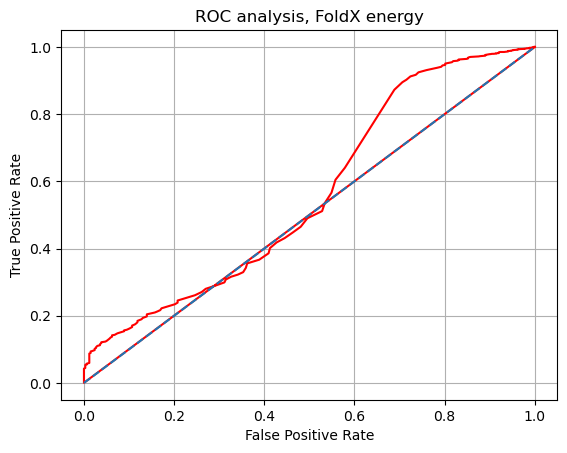

In [14]:
## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(-5,20, 0.01):
    pred = []
    for item in plotting_frame["RSA_Foldx_interaction"]:
        predvalue = 1 if item >= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, FoldX energy")

plt.grid()
plt.show()

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
499,-0.01,0.706231,0.895007,0.594388
497,-0.03,0.724036,0.912261,0.594113
498,-0.02,0.715134,0.902349,0.593608


A tpr of 89.5% is amazing, but unfortunately the fpr is also way too high. We can't be telling 70% of patients that they might have cancer when they don't. That wouldn't be great. So sadly, a naive multiplication of these two isn't a great form of prediction.